In [1]:
import pandas as pd
import os
from data_preparation import prepare_triplogs, prepare_tripdatas, get_clean_triplogs, get_clean_tripdatas, add_columns_to_prepared_triplogs

In [2]:
data_dir = "../2020_11_8_to_2020_11_14"

In [3]:
!ls ../2020_11_8_to_2020_11_14/CMS

intersectionstatusreport.csv
intersectionstatusreport_data_dictionary.docx
opticomdevicelog.csv
opticomdevicelog_data_dictonary.docx


In [4]:
tripdatas_df = pd.read_csv(os.path.join(data_dir, "CVP/tripdatas.csv"))

In [5]:
triplogs_df = pd.read_csv(os.path.join(data_dir, "CVP/triplogs.csv"))

In [ ]:
triplogs_df = prepare_triplogs(triplogs_df)
tripdatas_df = prepare_tripdatas(tripdatas_df)

# takes about 10 minutes to run

tripdatas_df = get_clean_tripdatas(tripdatas_df) # cleaning tripdatas first is important
tripdatas_df_good = tripdatas_df[tripdatas_df["is_good_for_study"]]
triplogs_df = get_clean_triplogs(triplogs_df, tripdatas_df_good)
triplogs_df_good = triplogs_df[triplogs_df["is_good_for_study"]]

triplogs_df_good = add_columns_to_prepared_triplogs(triplogs_df_good, tripdatas_df_good)

In [7]:
triplogs_df_good[["clear_taveltime", "duration_timedelta", "time_spent_on_busstops"]].head()

,clear_taveltime,duration_timedelta,time_spent_on_busstops
1,0 days 00:45:04.929000,0 days 01:07:51.034000,0 days 00:22:46.105000
3,0 days 00:53:06.896000,0 days 01:10:45.127000,0 days 00:17:38.231000
4,0 days 00:55:52.163000,0 days 01:05:33.813000,0 days 00:09:41.650000
5,0 days 00:47:39.833000,0 days 00:55:22.579000,0 days 00:07:42.746000
14,0 days 00:52:50.817000,0 days 01:02:57.660000,0 days 00:10:06.843000


In [8]:
triplogs_df_good["clear_taveltime_seconds"] = triplogs_df_good["clear_taveltime"].dt.total_seconds()

/Users/mkmet/opt/anaconda3/envs/gtt_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
triplogs_df_good["clear_taveltime_seconds"].head()

1     2704.929
3     3186.896
4     3352.163
5     2859.833
14    3170.817
Name: clear_taveltime_seconds, dtype: float64

In [10]:
import numpy as np
triplogs_on = triplogs_df_good[triplogs_df_good.tspmode == 'alwaysOn'].groupby(['routename', 'direction'])['clear_taveltime_seconds'].apply(list)
triplogs_on = triplogs_on.apply(lambda x: np.array(x))

In [11]:
triplogs_off = triplogs_df_good[triplogs_df_good.tspmode == 'alwaysOff'].groupby(['routename', 'direction'])['clear_taveltime_seconds'].apply(list)
triplogs_off = triplogs_off.apply(lambda x: np.array(x))

In [12]:
triplogs_off_idx = triplogs_off.apply(lambda x: len(x) > 3)
triplogs_off = triplogs_off[triplogs_off_idx]
print(triplogs_off.shape)

triplogs_on_idx = triplogs_on.apply(lambda x: len(x) > 3)
triplogs_on = triplogs_on[triplogs_on_idx]


print(triplogs_on.shape)

(64,)
(42,)


In [13]:
from scipy import stats
# mann-whitney u-test
def mannwhitney(triplogs_on, triplogs_off):
    rejected = []
    num_errors = 0
    for idx in triplogs_on.index:
        if idx in triplogs_off.index:
            try:
                pval = stats.mannwhitneyu(triplogs_on[idx], triplogs_off[idx], alternative='less').pvalue
                if pval < 0.05:
                    pass
                    #print(idx, f'route is significally faster with pval {pval:.2f}')
                rejected.append(
                    (pval, idx)
                )
            except ValueError:
                num_errors += 1
            
    print(len(rejected), 'of', len(triplogs_on.index), 'rejected', len(rejected)/len(triplogs_on.index))
    return rejected, num_errors

In [14]:
# student two samples t-test
def student(triplogs_on, triplogs_off):
    rejected = []
    num_errors = 0
    for idx in triplogs_on.index:
        if idx in triplogs_off.index:   
            pval = stats.ttest_ind(triplogs_on[idx], triplogs_off[idx], alternative='less').pvalue
            if pval < 0.05:
                # check same variance assumption (timings of two type of routes must have variance close to each other)
                s1 = np.sqrt(np.var(triplogs_on[idx], ddof=1))
                s2 = np.sqrt(np.var(triplogs_off[idx], ddof=1))
                valid = 'test valid'
                if np.abs(s1 - s2) > 3:
                    num_errors += 1
                else:
                    rejected.append(
                        (pval, idx)
                    )
    print(len(rejected), 'of', len(triplogs_on.index), 'rejected', len(rejected)/len(triplogs_on.index))
    return rejected, num_errors

In [15]:
def plot_trips(triplogs_on, triplogs_off, rejected_idxs):
    fig, ax = plt.subplots(len(rejected_idxs), 1,figsize=(15,15), constrained_layout=True)
    for i, (pval, idx)  in enumerate(rejected_idxs):
        title = f'{", ".join(map(str, idx))}, pval {pval:.2f}'
        ax[i].set_title(title)
        ax[i].plot(triplogs_on[idx], label='on')
        ax[i].plot(triplogs_off[idx], label='off')
        ax[i].legend()

In [16]:
triplogs_on.head()

routename  direction
1          inbound      [2061.965, 579.63, 1822.7720000000002, 1930.27...
           outbound     [1826.88, 2289.1400000000003, 2318.183, 1677.2...
12         outbound     [713.123, 636.575, 463.42800000000005, 551.098...
14R        inbound      [2611.387, 2341.664, 2701.221, 2084.308, 2630....
           outbound     [1893.1160000000002, 2348.05, 2221.105, 2690.8...
Name: clear_taveltime_seconds, dtype: object

39 of 42 rejected 0.9285714285714286
number of errors: 0


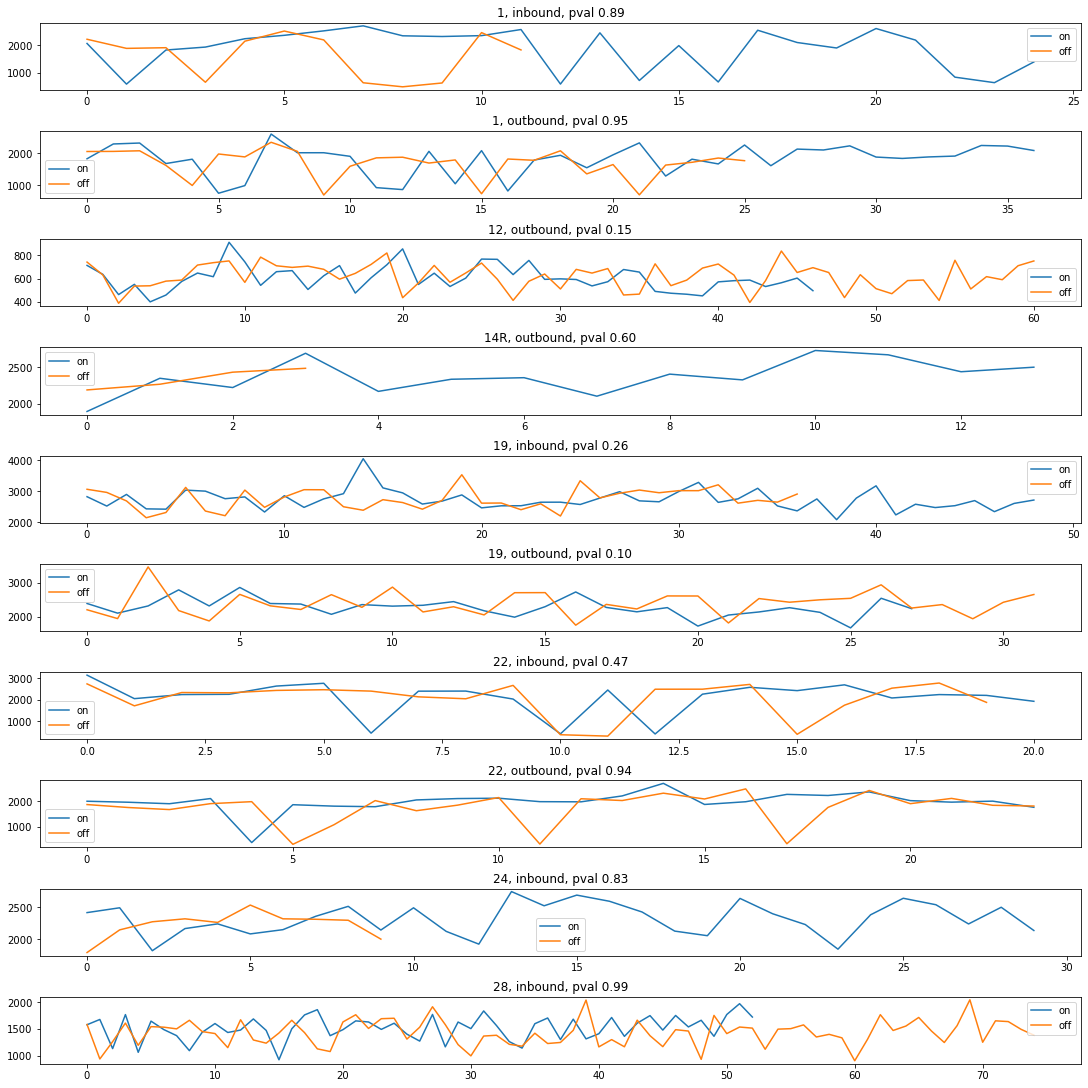

In [17]:
import matplotlib.pyplot as plt
rejected_idxs_manw, num_errs = mannwhitney(triplogs_on, triplogs_off)
print("number of errors:", num_errs)
plot_trips(triplogs_on, triplogs_off, rejected_idxs_manw[:10])

In [18]:
rejected_idxs_stud, num_errs = student(triplogs_on, triplogs_off)
print("number of errors:", num_errs)

0 of 42 rejected 0.0
number of errors: 3


## Hourly separation

In [19]:
triplogs_on = triplogs_df_good[triplogs_df_good.tspmode == 'alwaysOn'].groupby(['routename', 'direction', "starthour"])['clear_taveltime_seconds'].apply(list)
triplogs_on = triplogs_on.apply(lambda x: np.array(x))

In [20]:
triplogs_off = triplogs_df_good[triplogs_df_good.tspmode == 'alwaysOff'].groupby(['routename', 'direction', "starthour"])['clear_taveltime_seconds'].apply(list)
triplogs_off = triplogs_off.apply(lambda x: np.array(x))

In [21]:
# drop less that 3 obserations
triplogs_off_idx = triplogs_off.apply(lambda x: len(x) > 3)
triplogs_off = triplogs_off[triplogs_off_idx]
print(triplogs_off.shape)

triplogs_on_idx = triplogs_on.apply(lambda x: len(x) > 3)
triplogs_on = triplogs_on[triplogs_on_idx]
print(triplogs_on.shape)

(437,)
(257,)


192 of 257 rejected 0.7470817120622568
number of errors 0


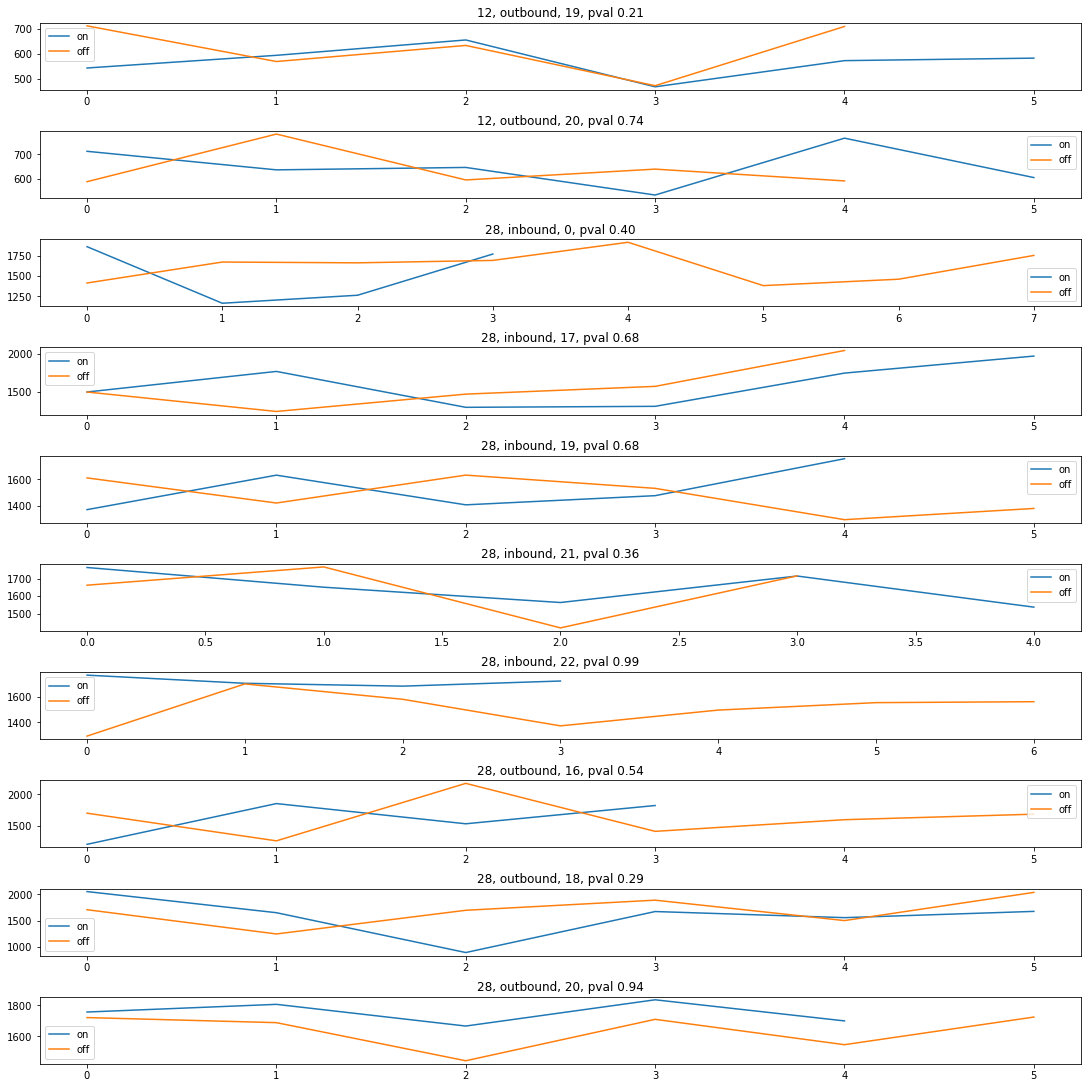

In [22]:
rejected_idxs_man, num_errs = mannwhitney(triplogs_on, triplogs_off)
print("number of errors", num_errs)
plot_trips(triplogs_on, triplogs_off, rejected_idxs_man[:10])

In [23]:
rejected_idxs_stud, num_errs = student(triplogs_on, triplogs_off)
print("number of errors", num_errs)

1 of 257 rejected 0.0038910505836575876
number of errors 13
